In [73]:
import numpy as np
import pandas as pd
import json
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from pdbbind_data_processor import PDBBindDataProcessor

In [74]:
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'

In [84]:
import pdbbind_data_processor
import importlib
importlib.reload(pdbbind_data_processor)
PDBBindDataProcessor = pdbbind_data_processor.PDBBindDataProcessor

In [87]:
pdbbind_data_processor = PDBBindDataProcessor()
pdbbind_df = pdbbind_data_processor.get_master_dataframe()

In [131]:
pdbbind_df.head()

,PDB code,resolution,release year_x,-logKd/Ki,Kd/Ki,reference,ligand name,activity_list,sep,value,units,release year_y,Uniprot ID,protein name,active
0,3zzf,2.20,2012,0.40,Ki=400mM //,3zzf.pdf,(NLG),"[mM, =, 400]",=,400000000.0,nM,2012,Q01217,ACETYLGLUTAMATE KINASE,False
1,3gww,2.46,2009,0.45,IC50=355mM //,3gwu.pdf,(SFX),"[mM, =, 355]",=,355000000.0,nM,2009,O67854,TRANSPORTER,False
2,1w8l,1.80,2004,0.49,Ki=320mM //,1w8l.pdf,(1P3),"[mM, =, 320]",=,320000000.0,nM,2004,P62937,PEPTIDYL-PROLYL CIS-TRANS ISOMERASE A,False
3,3fqa,2.35,2009,0.49,IC50=320mM //,3fq7.pdf,(GAB&PMP),"[mM, =, 320]",=,320000000.0,nM,2009,P24630,"GLUTAMATE-1-SEMIALDEHYDE 2,1-AMINOMUTASE",False
4,1zsb,2.00,1996,0.60,Kd=250mM //,1zsb.pdf,(AZM),"[mM, =, 250]",=,250000000.0,nM,1996,P00918,CARBONIC ANHYDRASE 2,False


In [101]:
pdbbind_df_no_mer = pdbbind_df[pdbbind_df['ligand name'].apply(lambda x : not 'mer' in x)]
ligand_counts = pdbbind_df_no_mer['ligand name'].value_counts()

In [102]:
ligand_counts = pd.DataFrame(ligand_counts)

In [94]:
ligand_protein_counts = pdbbind_df_no_mer[['ligand name', 'protein name']].value_counts()
ligand_unique_proteins_count = ligand_protein_counts.groupby('ligand name').count()
ligand_counts['unique_proteins'] = ligand_unique_proteins_count

In [110]:
top50_ligand_counts = ligand_counts[:50]
top50_ligand = top50_ligand_counts.index.tolist()

In [111]:
top50_ligand_counts.head()

,ligand name,unique_proteins
(ADP),80,63
(ATP),75,57
(GDP),56,46
(017),40,5
(SAH),39,33


In [23]:
frac_train = 0.8

In [113]:
chembl_targets = pd.read_csv('chembl_targets.csv', sep=';')

In [148]:
chembl_targets.tail()

,ChEMBL ID,Name,UniProt Accessions,Type,Organism,Compounds,Activities,Tax ID,Species Group Flag
14549,CHEMBL3080,Chitinase 1,Q13231,SINGLE PROTEIN,Homo sapiens,105.0,117.0,9606.0,False
14550,CHEMBL1075542,NCI-H441,NaN,CELL-LINE,Homo sapiens,160.0,182.0,9606.0,False
14551,CHEMBL3259506,Neuropathy target esterase,Q3TRM4,SINGLE PROTEIN,Mus musculus,21.0,29.0,10090.0,False
14552,CHEMBL3430871,Dimethylaniline monooxygenase [N-oxide-forming] 5,P49326,SINGLE PROTEIN,Homo sapiens,3.0,13.0,9606.0,False
14553,CHEMBL2189159,"Indoleamine 2,3-dioxygenase 2",Q8R0V5,SINGLE PROTEIN,Mus musculus,93.0,105.0,10090.0,False


In [140]:
def get_uniprot_to_chembl(chembl_table) :
    chembl_table = chembl_table[chembl_table['Type'] == 'PROTEIN FAMILY']
    chembl_table = chembl_table.dropna(subset=['UniProt Accessions'])
    table = pd.DataFrame()
    for i in chembl_table.index :
        chembl_id = chembl_table.loc[i, 'ChEMBL ID']
        uniprot_ids = chembl_table.loc[i, 'UniProt Accessions']
        l_uniprot_ids = uniprot_ids.split('|')
        for uniprot_id in l_uniprot_ids :
            table = table.append({'ChEMBL ID' : chembl_id,
                          'UniProt Accessions' : uniprot_id}, ignore_index=True)
            
    return table

In [154]:
uniprot_to_chembl = get_uniprot_to_chembl(chembl_targets)

In [155]:
for uniprot_id in pdbbind_df_no_mer['Uniprot ID'].unique() :
    if not uniprot_id in uniprot_to_chembl['UniProt Accessions'].values :
        uniprot_to_chembl = uniprot_to_chembl.append({'ChEMBL ID' : np.nan,
                                                      'UniProt Accessions' : uniprot_id}, ignore_index=True)

In [156]:
uniprot_to_chembl.head()

,ChEMBL ID,UniProt Accessions
0,CHEMBL4630725,P29475
1,CHEMBL4630725,P35228
2,CHEMBL4630725,P29474
3,CHEMBL2363071,P28702
4,CHEMBL2363071,P13631


In [157]:
uniprot_to_chembl.shape

(4409, 2)

In [135]:
uniprot_id = 'P34972'
uniprot_to_chembl[uniprot_to_chembl['UniProt Accessions'] == uniprot_id]

,ChEMBL ID,UniProt Accessions
1982,CHEMBL2096981,P34972
7530,CHEMBL253,P34972


In [136]:
chembl_id = 'CHEMBL2096981'
chembl_targets[chembl_targets['ChEMBL ID'] == chembl_id]

,ChEMBL ID,Name,UniProt Accessions,Type,Organism,Compounds,Activities,Tax ID,Species Group Flag
1737,CHEMBL2096981,Cannabinoid receptor,P34972|P21554,PROTEIN FAMILY,Homo sapiens,229.0,238.0,9606.0,False


In [137]:
chembl_id = 'CHEMBL253'
chembl_targets[chembl_targets['ChEMBL ID'] == chembl_id]

,ChEMBL ID,Name,UniProt Accessions,Type,Organism,Compounds,Activities,Tax ID,Species Group Flag
7900,CHEMBL253,Cannabinoid CB2 receptor,P34972,SINGLE PROTEIN,Homo sapiens,9010.0,15481.0,9606.0,False


In [134]:
uniprot_id = 'P34972'
chembl_targets[chembl_targets['UniProt Accessions'] == uniprot_id]

,ChEMBL ID,Name,UniProt Accessions,Type,Organism,Compounds,Activities,Tax ID,Species Group Flag
7900,CHEMBL253,Cannabinoid CB2 receptor,P34972,SINGLE PROTEIN,Homo sapiens,9010.0,15481.0,9606.0,False


In [143]:
pdbbind_df_no_mer.shape

(16844, 15)

In [158]:
pdbbind_df_no_mer_family = pdbbind_df_no_mer.merge(uniprot_to_chembl, left_on='Uniprot ID', right_on='UniProt Accessions')

In [173]:
pdb_id_counts = pdbbind_df_no_mer_family['PDB code'].value_counts()
multiple_families_pdb_ids = pdb_id_counts[pdb_id_counts > 1].index

In [174]:
multiple_families_pdb_ids

Index(['4lxz', '3max', '5iwg', '5ix0', '4ly1', '6g3o', '5kh3', '3mz3', '4rn2',
       '6hsk',
       ...
       '3eoc', '5tbp', '3fz1', '2a0c', '5ekn', '6dkg', '5ml2', '2ovz', '3g45',
       '5hg9'],
      dtype='object', length=1243)

In [186]:
a = pdbbind_df_no_mer_family[pdbbind_df_no_mer_family['PDB code'].isin(multiple_families_pdb_ids)]

In [187]:
b = chembl_targets[chembl_targets['ChEMBL ID'].isin(a['ChEMBL ID'].unique())] 

In [25]:
available_structures = os.listdir(pdbbind_general_dir) + os.listdir(pdbbind_refined_dir)
train_set = {}
test_set = {}
for lig in top50_ligand_counts.index :
    pl_lig = pl_all[pl_all['ligand name'] == lig]
    pl_lig = pl_lig[pl_lig['PDB code'].isin(available_structures)]
    
    if len(pl_lig) > 10 :
        train_pdbs = []
        test_pdbs = []
        counter = Counter()
        counter.update(pl_lig['protein name'].values)
        if len(counter) > 1 :
            for prot_name, count in counter.most_common() :
                pdb_ids = pl_lig[pl_lig['protein name'] == prot_name]['PDB code'].values
                if len(train_pdbs) < len(pl_lig) * 0.7 :
                    train_pdbs.extend(pdb_ids)
                else :
                    test_pdbs.extend(pdb_ids)
            train_set[lig] = train_pdbs
            test_set[lig] = test_pdbs

In [28]:
import numpy as np
import json
import pickle
import os
from ase.io import read as aseread

from dscribe.descriptors import SOAP

from scipy.spatial.distance import euclidean
from scipy.spatial import distance_matrix
from collections import defaultdict
from Bio.PDB import PDBParser, PPBuilder

import warnings
warnings.filterwarnings('ignore')

In [29]:
pdbbind_general_dir = '../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/'
pdbbind_refined_dir = '../PDBBind/PDBbind_v2020_refined/refined-set/'

In [30]:
def get_soap_calculator(rcut=5, nmax=8, lmax=4, sigma=1):
    return SOAP(
        rcut = rcut,
        nmax = nmax,
        lmax = lmax,
        sigma = sigma,
        species = "C,N,O,S".split(",")
    )

In [31]:
def get_protein_config(prot_id, input_dirs=['../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/',
                                                      '../PDBBind/PDBbind_v2020_refined/refined-set/']) :
    """
    Returns an Atoms object of the protein for a given pdb + chain names 
    (and class to look in the right directory)
    """

    if prot_id in os.listdir(input_dirs[0]) :
        protein_path = os.path.join(input_dirs[0], prot_id, f'{prot_id}_protein.pdb')
    else :
        protein_path = os.path.join(input_dirs[1], prot_id, f'{prot_id}_protein.pdb')
        
    config = aseread(protein_path)
    config = config[[atom.index for atom in config if atom.symbol in ['C', 'N', 'O', 'S']]]
        
    return config

In [32]:
def get_ligand_config(prot_id, input_dirs=['../PDBBind/PDBbind_v2020_other_PL/v2020-other-PL/',
                                                      '../PDBBind/PDBbind_v2020_refined/refined-set/']) :
    """
    Returns an Atoms object for a given protein name (and class to look in the right directory)
    """
    
    if prot_id in os.listdir(input_dirs[0]) :
        ligand_path = os.path.join(input_dirs[0], prot_id, f'{prot_id}_ligand.sdf')
    else :
        ligand_path = os.path.join(input_dirs[1], prot_id, f'{prot_id}_ligand.sdf')
        
    config = aseread(ligand_path, format='sdf')

    # config = config[[atom.index for atom in config if atom.symbol in ['C', 'N', 'O', 'S']]] 
    # we comment out because we are interested in all ligand atoms positions
        
    return config

In [33]:
def sample_around_pos(calculator, config, position, shift_radius=0.5, sample_size=2) :
    """
    Sample SOAPS at positions around the given position
    """
    
    limited_config = config[distance_matrix(config.positions, position.reshape(1, -1)).max(1) < 10]
    
    shifts = (np.random.rand(sample_size, 3) - 0.5) * 2 * shift_radius
    shifted_positions = shifts + position
    
    soaps = []
    for shifted_position in shifted_positions :
        soaps.append(calculator.create(system=config, positions=[shifted_position.tolist()])[0])
        #soaps.append(calculator.create(system=config, positions=[shifted_position.tolist()])[0])
                
    return soaps

In [34]:
def random_sample_protein(calculator, config, ligand_positions, sample_size=5) :
    """
    Sample SOAPS at random positions in the protein, only if they are not close to ligand
    """
    
    config_mins = config.positions.min(axis=0).astype(int) - 5
    config_maxs = config.positions.max(axis=0).astype(int) + 5
    
    soaps = []
    random_positions = np.random.rand(sample_size, 3) * (config_maxs - config_mins) + config_mins
    for position in random_positions :
        close_to_ligand = any([euclidean(position, ligand_position) < 3 for ligand_position in ligand_positions])
        if not close_to_ligand : # avoid putting positive (close to the ligand) soaps in random = negative soaps
            soap = calculator.create(system=config, positions=[position.tolist()])[0]
            if not any(np.isnan(soap)) : # avoid soap errors
                soaps.append(soap)
    
    return soaps

In [35]:
data_dir = 'data/'

In [36]:
training_set = json.load(open("data/pdbbind_ligand_training_set.json")) # {kinase_class : [prot_id1, prot_id2...]}
test_set = json.load(open("data/pdbbind_ligand_test_set.json"))

In [37]:
%%time

training_soaps = defaultdict(list) # {class_id : [soap1, soap2...]} with soap = [value1, ..., value1800]

for class_id in training_set :
    
    for prot_id in training_set[class_id] :

        prot_soaps = []
        try :
        
            calculator = get_soap_calculator()

            protein_config = get_protein_config(prot_id)
            ligand_config = get_ligand_config(prot_id)
            
            for position in ligand_config.positions :
                soaps = sample_around_pos(calculator, protein_config, position)
                prot_soaps.extend(soaps)
                
            training_soaps[class_id].extend(prot_soaps)
            
        except : 
            print('Error reading ' + prot_id)
    
    training_soaps[class_id] = np.array(training_soaps[class_id])
    print(class_id + ' done')
    print(training_soaps[class_id].shape)
    
training_soaps['random'] = np.array(training_soaps['random'])

(ADP) done
(4704, 2640)
(ATP) done
(4982, 2640)
(GDP) done
(3372, 2640)
(017) done
(5100, 2640)
(SAH) done
(2594, 2640)
(C2E) done
(3324, 2640)
(AMP) done
(1554, 2640)
(BTN) done
(1280, 2640)
(ARG) done
(998, 2640)
(SAM) done
(1734, 2640)
(G39) done
(1826, 2640)
(STU) done
(1982, 2640)
(GLU) done
(640, 2640)
(BEN) done
(578, 2640)
(PGA) done
(364, 2640)
(GTP) done
(1204, 2640)
(ANP) done
(1248, 2640)
(AZM) done
(456, 2640)
(TRP) done
(648, 2640)
(CIT) done
(504, 2640)
Error reading 4qgi
Error reading 3ekq
Error reading 3el4
Error reading 3cyx
Error reading 3d1y
Error reading 2nmy
Error reading 2nmz
Error reading 2nnk
Error reading 2nnp
Error reading 3oxc
Error reading 3d1x
Error reading 3s56
Error reading 1hxb
(ROC) done
(0,)
Error reading 2avq
Error reading 2aoc
Error reading 2aod
Error reading 2avm
Error reading 2aog
Error reading 6o57
Error reading 6o5a
Error reading 3hau
Error reading 3bva
Error reading 3hdk
Error reading 3hbo
Error reading 3iaw
(2NC) done
(0,)
(ADN) done
(774, 264

# Compute SOAPS for test set

In [38]:
%%time

test_soaps = defaultdict(list)

for class_id in test_set :
    
    for prot_id in test_set[class_id] :

        prot_soaps = []
        try :
        
            calculator = get_soap_calculator()

            protein_config = get_protein_config(prot_id)
            ligand_config = get_ligand_config(prot_id)
            
            for position in ligand_config.positions :
                soaps = sample_around_pos(calculator, protein_config, position)
                prot_soaps.extend(soaps)
                
            test_soaps[class_id].extend(prot_soaps)
                
        except : 
            print('Error reading ' + prot_id)
    
    test_soaps[class_id] = np.array(test_soaps[class_id])
    print(class_id + ' done')
    print(test_soaps[class_id].shape)

(ADP) done
(2016, 2640)
(ATP) done
(2068, 2640)
(GDP) done
(1352, 2640)
(017) done
(892, 2640)
(SAH) done
(1034, 2640)
(C2E) done
(1316, 2640)
(AMP) done
(666, 2640)
(BTN) done
(512, 2640)
(ARG) done
(378, 2640)
Error reading 2adm
(SAM) done
(464, 2640)
(G39) done
(270, 2640)
(STU) done
(756, 2640)
(GLU) done
(240, 2640)
(BEN) done
(102, 2640)
(PGA) done
(140, 2640)
(GTP) done
(412, 2640)
(ANP) done
(422, 2640)
(AZM) done
(190, 2640)
(TRP) done
(270, 2640)
(CIT) done
(168, 2640)
Error reading 3pww
Error reading 5kqx
Error reading 5kr2
(ROC) done
(0,)
Error reading 3haw
Error reading 3hlo
Error reading 3ka2
Error reading 3fsm
(2NC) done
(0,)
(ADN) done
(256, 2640)
(DAN) done
(296, 2640)
(CMP) done
(272, 2640)
Error reading 2p3d
Error reading 3slz
(3TL) done
(132, 2640)
(478) done
(420, 2640)
(OAN) done
(264, 2640)
(5GP) done
(290, 2640)
(GSH) done
(296, 2640)
(RET) done
(288, 2640)
(AKG) done
(96, 2640)
(AGS) done
(282, 2640)
(ZMR) done
(266, 2640)
(MK1) done
(188, 2640)
(BO2) done
(106

In [40]:
data_dir = 'data/'

In [42]:
X = np.empty((0, training_soaps['(ADP)'].shape[1]))
Y = []

for class_id in training_soaps :
    if class_id != 'random' :
        if len(training_soaps[class_id]) :
            X = np.vstack((X, training_soaps[class_id]))
            Y += [class_id for _ in range(training_soaps[class_id].shape[0])]
        
enc = OneHotEncoder()
Y_enc = enc.fit_transform(np.array(Y).reshape(-1,1)).toarray()
class_ids = enc.categories_[0]
        
X_train = X
Y_train = Y_enc

In [43]:
training_soaps['(BO2)'].shape

(1272, 2640)

In [44]:
X_test = np.empty((0, training_soaps['(ADP)'].shape[1]))
Y_test = []

for class_id in test_soaps :
    if class_id != 'random' :
        if len(training_soaps[class_id]) :
            X_test = np.vstack((X_test, test_soaps[class_id]))
            Y_test += [class_id for _ in range(test_soaps[class_id].shape[0])]
        
Y_test = enc.fit_transform(np.array(Y_test).reshape(-1,1)).toarray()

In [45]:
reg = MultiOutputRegressor(LinearRegression())
reg.fit(X_train, Y_train)

MultiOutputRegressor(estimator=LinearRegression())

In [47]:
training_set_sizes = [len(training_soaps[class_id]) for class_id in class_ids]
training_set_sizes = np.array(training_set_sizes)

In [51]:
from evaluate_regressor import RegressorEvaluator

In [69]:
import evaluate_regressor
import importlib
importlib.reload(evaluate_regressor)
RegressorEvaluator = evaluate_regressor.RegressorEvaluator

In [70]:
evaluator = RegressorEvaluator(reg, class_ids)

Balanced accuracy : 0.25284832765520543


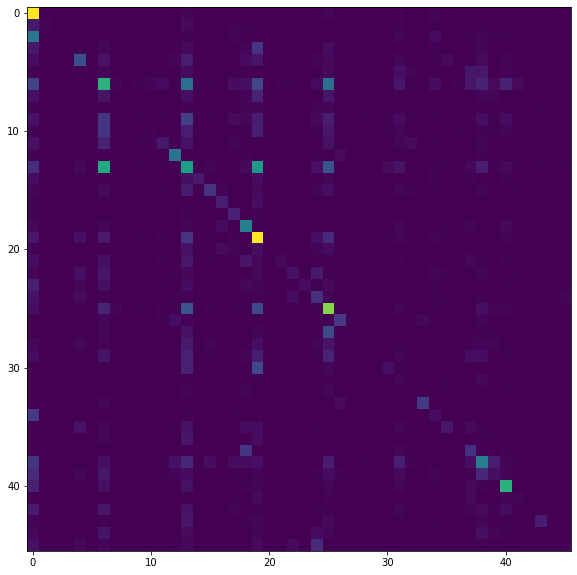

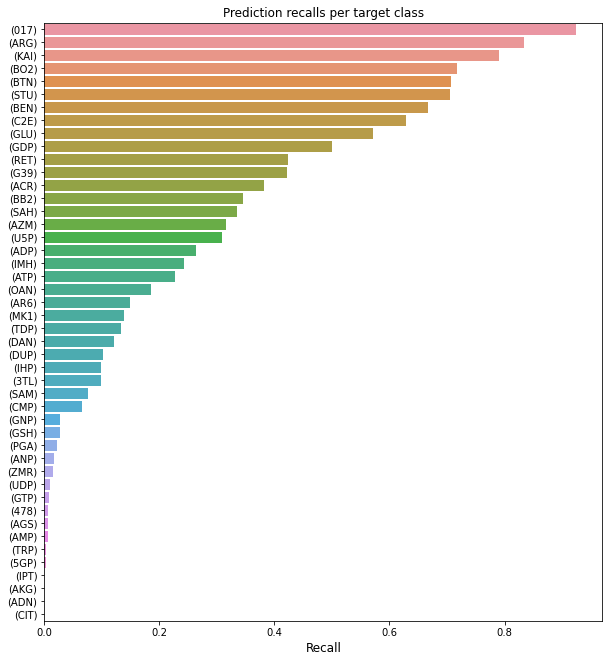

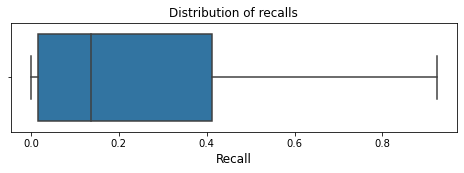

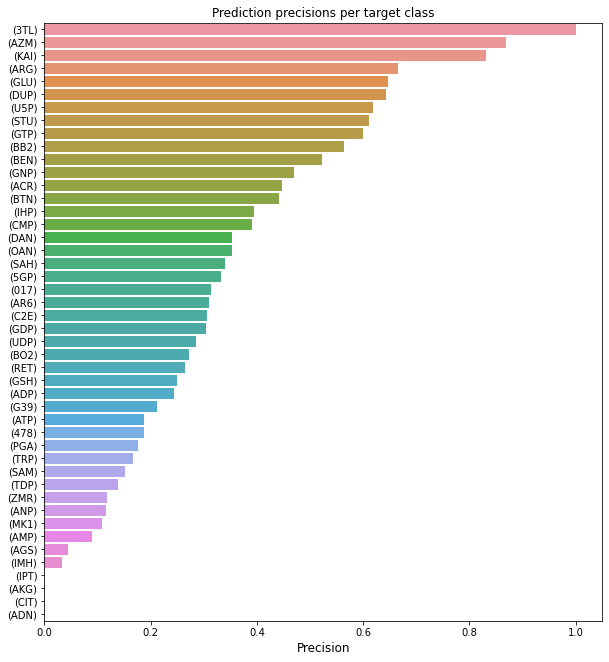

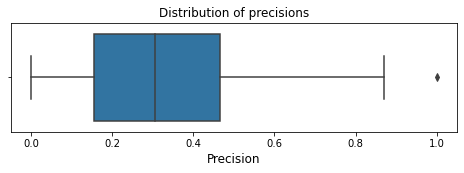

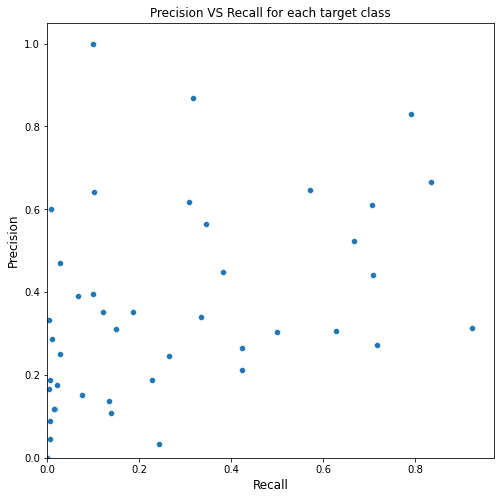

(017) instead of (478) has a rate of 78.33 %
(017) instead of (MK1) has a rate of 72.87 %
(GDP) instead of (GNP) has a rate of 66.55 %
(C2E) instead of (IHP) has a rate of 56.48 %
(BTN) instead of (RET) has a rate of 45.83 %
(017) instead of (3TL) has a rate of 45.45 %
(C2E) instead of (5GP) has a rate of 43.79 %
(G39) instead of (ZMR) has a rate of 37.59 %
(ATP) instead of (PGA) has a rate of 36.43 %
(ADP) instead of (ANP) has a rate of 31.75 %
(C2E) instead of (AGS) has a rate of 28.01 %
(017) instead of (DUP) has a rate of 27.65 %
(SAH) instead of (IMH) has a rate of 27.27 %
(C2E) instead of (BEN) has a rate of 25.49 %
(RET) instead of (TDP) has a rate of 24.44 %
(ADP) instead of (ATP) has a rate of 24.27 %
(ATP) instead of (AMP) has a rate of 23.72 %
(ATP) instead of (IHP) has a rate of 23.46 %
(C2E) instead of (TDP) has a rate of 23.33 %
(ATP) instead of (CIT) has a rate of 23.21 %
(ATP) instead of (U5P) has a rate of 23.04 %
(ATP) instead of (IPT) has a rate of 22.73 %
(ADP) inst

In [71]:
evaluator.evaluate_regressors_performances(X_test, Y_test, plot_suffix='pdbbind_ligand')